In [1]:
git_repo = '../../../../'

import sys
import os
import glob

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))
sys.path.insert(0, '../../../../LinearResponseVariationalBayes.py/')

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib
import LinearResponseVariationalBayes.OptimizationUtils as opt_lib

import LinearResponseVariationalBayes.ModelSensitivity as model_sens

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

from autograd import numpy as np
from autograd import scipy as sp

# import numpy as np
# import scipy as sp

np.random.seed(453453)

import json 

# Load original model

In [2]:
fit_dir = './iris_fits_for_nips/'

In [42]:
json_input_file = os.path.join(fit_dir, 'bnp_full_data_fit_alpha10_iris.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)
    prior_param_vec0 = model.prior_params.get_vector()
    
moment_model = gmm_utils.InterestingMoments(model)


In [43]:
alpha0 = model.prior_params['alpha'].get()
print(alpha0)

[10.]


# Set up linear sensitivity class

In [44]:
# this is analagous to the moment model, but for expected number of clusters
e_num_clusters_class = gmm_utils.ExpectedNumClustersFromZ(model)
e_num_clusters_class.set_e_num_clusters_from_free_param(best_param)

linear_sensitivity = \
    obj_lib.ParametricSensitivity(\
        objective_fun =             model.set_z_get_kl,\
        input_par =                 model.global_vb_params,\
        output_par =                e_num_clusters_class.e_num_clusters,\
        hyper_par =                 model.prior_params,\
        input_to_output_converter = e_num_clusters_class.set_e_num_clusters,\
        optimal_input_par =         best_param,\
        objective_hessian =         kl_hessian)


# linear_sensitivity = \
#     model_sens.ParametricSensitivityTaylorExpansion(\
#         objective_functor =         model.set_z_get_kl,\
#         input_par =                 model.global_vb_params,\
#         hyper_par =                 model.prior_params,\
#         input_val0 = best_param, 
#         hyper_val0 = prior_param_vec0, 
#         order = 2, 
#         hess0 = kl_hessian)


/home/rgiordan/Documents/git_repos/autograd/autograd/numpy/numpy_vjps.py:269: RuntimeWarning: invalid value encountered in true_divide
  return g_repeated / x


# Load refitted models and get linear approximations 

In [45]:
files = glob.glob(fit_dir +  '/bnp_full_data_fit_alpha*_iris.json')

In [46]:
free_par_refit_list = []
free_par_lr_list = []

out_par_lr_list = []
out_par_refit_list = []

alpha_vec = np.zeros(len(files))

for i in range(len(files)): 
    
    # load perturbed model 
    #json_input_file = os.path.join(fit_dir, files[i])
    json_input_file = os.path.join(files[i])

    with open(json_input_file, 'r') as fp:
        fit_dict = json.load(fp)
        model_refit = gmm_utils.get_model_from_checkpoint(fit_dict)
    
    # prior parameters from refitted model
    alpha_vec[i] = model_refit.prior_params['alpha'].get()
    prior_param_vec_pert = model_refit.prior_params.get_vector() 

    # get free parameters from the refitted model 
    free_par_refit = model_refit.global_vb_params.get_free()
    free_par_refit_list.append(free_par_refit)
    
    # linear approximation for free params
    free_par_lr = linear_sensitivity.predict_input_par_from_hyperparameters(prior_param_vec_pert) 
    free_par_lr_list.append(free_par_lr)
    
    # linear approximation for num clusters
    out_par_lr = linear_sensitivity.predict_output_par_from_hyperparameters(prior_param_vec_pert, linear = False)
    out_par_lr_list.append(out_par_lr)
    
    # refitted num clusters
    model_refit.set_optimal_z()
    out_par_refit = modeling_lib.get_e_number_clusters_from_ez(model_refit.e_z)
    out_par_refit_list.append(out_par_refit)


In [47]:
alpha_vec

array([ 2. ,  1. ,  4. , 20. , 26. , 16. , 22. ,  4.5, 28. ,  5.5,  1.5,
        5. , 18. ,  2.5,  3.5,  6. , 12. ,  2. ,  3. ,  4. ,  6. , 24. ,
        8. ,  0.5,  6.5, 14. , 10. ])

### Check the free parameters

In [48]:
# for i in range(len(free_par_refit_list)): 
#     plt.figure()
#     plt.plot(free_par_lr_list[i]- best_param, free_par_refit_list[i] - best_param, '+')
#     plt.plot(free_par_lr_list[i]- best_param, free_par_lr_list[i]- best_param, '-')
#     plt.title('alpha = {}'.format(alpha_vec[i]))

# Plot results on expected number of clusters

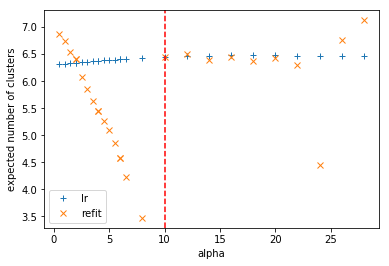

In [49]:
plt.plot(alpha_vec, out_par_lr_list, '+')
plt.plot(alpha_vec, out_par_refit_list, 'x')

plt.axvline(x=alpha0, linestyle = '--', color = 'red')

plt.xlabel('alpha')
plt.ylabel('expected number of clusters')

plt.legend(('lr', 'refit'))

In [50]:
print('Done.')

Done.
